아이돌 얼굴인식 kNN알고리즘 코드와 운전자인식 kNN알고리즘 코드는 다르다.  
해당 파일은 아이돌 얼굴인식 코드이다.

파이썬 가상환경에서 진행하였다.

1. 환경구축  
face_recognition 라이브러리를 설치 위해서는 cmake와 dlib를 먼저 설치해야한다.  
cmake는 pip install 이나 conda install 명령어로 설치할 수 있다.  
dlib는 가상환경 터미널에서 'conda install conda-forge dlib'라는 명령어로 설치할 수 있다.  
cmake와 dlib가 설치되었다면, pip install이나 conda install로 face_recognition 설치할 수 있다.  
2. dataset 검사  
얼굴인식이 되는 사진인지 검사한다 -> 얼굴이 인식되는 사진으로만 구성  
3. train


*dataset이 있는 경로와 train파일이 있는 경로가 같아야한다*  
*레퍼런스 : https://github.com/ageitgey/face_recognition , https://github.com/ageitgey/face_recognition/wiki/Calculating-Accuracy-as-a-Percentage*

# dataset 인식 확인

In [ ]:
# 파일 1개 확인
from PIL import Image, ImageDraw
import face_recognition
import os
import matplotlib.pyplot as plt
    # Load the jpg file into a numpy array
image = face_recognition.load_image_file("C:\\Users\\user\\Desktop\\캡스톤_얼굴인식\\knn\\블랙박스\\test_재석\\재석test.jpg")

    # Find all facial features in all the faces in the image
face_landmarks_list = face_recognition.face_landmarks(image)

print("I found {} face(s) in this photograph.".format(len(face_landmarks_list)))

    # Create a PIL imagedraw object so we can draw on the picture
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:

        # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        print("The {} in this face has the following points: {} \n".format(facial_feature, face_landmarks[facial_feature]))

        # Let's trace out each facial feature in the image with a line!
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=3)

    # Show the picture
#pil_image.show()
plt.imshow(pil_image)

In [ ]:
'''
    폴더안의 사진들 모두를 검사하고자 할 때
    
    train_dir : training 데이터가 있는 path
    person_dir : training 데이터 하위의 폴더(이름으로 구성)
    train
        ㄴperson1
            ㄴ001.jpg
            ㄴ002.jpg
        ㄴperson2
            ...
'''
from PIL import Image, ImageDraw
import face_recognition
import os
import matplotlib.pyplot as plt

# Load the jpg file into a numpy array
train_dir = "C:\\Users\\user\\Desktop\\캡스톤_얼굴인식\\knn\\블랙박스\\train_재석"
for person_name in os.listdir(train_dir):
    person_dir = train_dir+"\\{}".format(person_name)
    for i in os.listdir(person_dir):
        print(i)
        image = face_recognition.load_image_file(person_dir+'\\{}'.format(i))


        # Find all facial features in all the faces in the image
        face_landmarks_list = face_recognition.face_landmarks(image)

        print("I found {} face(s) in {} photograph.".format(len(face_landmarks_list),i))

        # Create a PIL imagedraw object so we can draw on the picture
        pil_image = Image.fromarray(image)
        d = ImageDraw.Draw(pil_image)

        for face_landmarks in face_landmarks_list:

            # Print the location of each facial feature in this image
            for facial_feature in face_landmarks.keys():
                print("The {} in this face has the following points: {} \n".format(facial_feature, face_landmarks[facial_feature]))

            # Let's trace out each facial feature in the image with a line!
            for facial_feature in face_landmarks.keys():
                d.line(face_landmarks[facial_feature], width=3)

        # Show the picture
        pil_image.show()
        #plt.imshow(pil_image)

# Function

In [4]:
"""
This is an example of using the k-nearest-neighbors (KNN) algorithm for face recognition.

When should I use this example?
This example is useful when you wish to recognize a large set of known people,
and make a prediction for an unknown person in a feasible computation time.

Algorithm Description:
The knn classifier is first trained on a set of labeled (known) faces and can then predict the person
in an unknown image by finding the k most similar faces (images with closet face-features under euclidean distance)
in its training set, and performing a majority vote (possibly weighted) on their label.

For example, if k=3, and the three closest face images to the given image in the training set are one image of Biden
and two images of Obama, The result would be 'Obama'.

* This implementation uses a weighted vote, such that the votes of closer-neighbors are weighted more heavily.

Usage:

1. Prepare a set of images of the known people you want to recognize. Organize the images in a single directory
   with a sub-directory for each known person.

2. Then, call the 'train' function with the appropriate parameters. Make sure to pass in the 'model_save_path' if you
   want to save the model to disk so you can re-use the model without having to re-train it.

3. Call 'predict' and pass in your trained model to recognize the people in an unknown image.

NOTE: This example requires scikit-learn to be installed! You can install it with pip:

$ pip3 install scikit-learn

"""

import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder
from sklearn import metrics
import matplotlib.pyplot as plt
import sys
import time

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}


def train(train_dir,val_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    """
    Trains a k-nearest neighbors classifier for face recognition.

    :param train_dir: directory that contains a sub-directory for each known person, with its name.

     (View in source code to see train_dir example tree structure)

     Structure:
        <train_dir>/
        ├── <person1>/
        │   ├── <somename1>.jpeg
        │   ├── <somename2>.jpeg
        │   ├── ...
        ├── <person2>/
        │   ├── <somename1>.jpeg
        │   └── <somename2>.jpeg
        └── ...

    :param model_save_path: (optional) path to save model on disk
    :param n_neighbors: (optional) number of neighbors to weigh in classification. Chosen automatically if not specified
    :param knn_algo: (optional) underlying data structure to support knn.default is ball_tree
    :param verbose: verbosity of training
    :return: returns knn classifier that was trained on the given data.
    """
    X_train = []
    y_train = []
    X_val =[]
    y_val = []
    # Loop through each person in the training set
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        # Loop through each training image for the current person
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)
            
            print("I found {} face(s) in {} train dataset.".format(len(face_bounding_boxes), img_path))
            
            # Print the location of each face in this sample image
            top, right, bottom, left = face_bounding_boxes[0]
            # You can access the actual face itself like this:
            face_image = image[top:bottom, left:right]
            pil_image = Image.fromarray(face_image)
            plt.title('representative train image using bounding box')
            plt.imshow(pil_image)
                
            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the training set
                X_train.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y_train.append(class_dir)
    
    # Loop through each person in the validation set
    for class_dir in os.listdir(val_dir):
        if not os.path.isdir(os.path.join(val_dir, class_dir)):
            continue

        # Loop through each training image for the current person
        for img_path in image_files_in_folder(os.path.join(val_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)
            # Print the location of each face in this sample image
            top, right, bottom, left = face_bounding_boxes[0]
            
            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for validation: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the validation set
                X_val.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y_val.append(class_dir)
    
    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    # training
    start_time = time.time()
    knn_clf.fit(X_train, y_train)
    Total_time = time.time() - start_time # time_taken is in seconds
    hours, rest = divmod(Total_time,3600)
    minutes, seconds = divmod(rest, 60)
    hour = math.trunc(hours)
    minute = math.trunc(minutes)
    second = math.trunc(seconds)
    print("총 소요시간: {}시간 {}분 {}초" .format(hour, minute, second))
    # predict
    y_pred = knn_clf.predict(X_val)
    # accuracy
    scores = metrics.accuracy_score(y_val, y_pred)
    print("Accuracy_score : ",scores)
    
    #confusion matrix
    disp = metrics.plot_confusion_matrix(knn_clf, X_val, y_val)
    plt.show()
    print(f"{metrics.classification_report(y_val, y_pred)}\n")
    
    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf


def predict(train_dir,X_img_path, knn_clf=None, model_path=None, distance_threshold=0.55):
    """
    Recognizes faces in given image using a trained KNN classifier

    :param X_img_path: path to image to be recognized
    :param knn_clf: (optional) a knn classifier object. if not specified, model_save_path must be specified.
    :param model_path: (optional) path to a pickled knn classifier. if not specified, model_save_path must be knn_clf.
    :param distance_threshold: (optional) distance threshold for face classification. the larger it is, the more chance
           of mis-classifying an unknown person as a known one.
    :return: a list of names and face locations for the recognized faces in the image: [(name, bounding box), ...].
        For faces of unrecognized persons, the name 'unknown' will be returned.
    """
    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(X_img_path))

    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)

    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces in the test iamge
    faces_encodings = face_recognition.face_encodings(X_img, 
                                                      known_face_locations=X_face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold 
                   for i in range(len(X_face_locations))]

    known_face_encodings=[]

    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue
        # Loop through each training image for the current person
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            known_image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(known_image)
            try:
                known_face_encodings.append(face_recognition.face_encodings(known_image, known_face_locations=face_bounding_boxes)[0])
                
            except IndexError as e:
                print(e)
                sys.exit(1) # stops code execution in my case you could handle it differently
            
    
    image_to_test = face_recognition.load_image_file(X_img_path)
    image_to_test_encoding = face_recognition.face_encodings(image_to_test)[0]
    
    # See how far apart the test image is from the known faces
    face_distances = face_recognition.face_distance(known_face_encodings, image_to_test_encoding)
    
    # face_distance code
    global accuracy
    acc =[]
    accuracy={}
    
    # print문 주석처리해도 됨
    for i, face_distance in enumerate(face_distances):
        print("The test image has a distance of {:.2} from known image #{}".format(face_distance, i))
        #print("- With a normal cutoff of 0.6, would the test image match the known image? {}".format(face_distance < 0.6))
        #print("- With a very strict cutoff of 0.5, would the test image match the known image? {}".format(face_distance < 0.5))
        acc.append(face_distance_to_conf(face_distance))
        print()

    # 모든 사람에 대해 각자 traing 파일이 몇 개 있는지, 그 중에서 가장 높은 accuracy(가장 낮은 distance)를 구함
    start=0
    for person_name in os.listdir(train_dir):
        number_of_files = os.listdir(train_dir+'/{}'.format(person_name))
        temp = len(number_of_files)
        result = max(acc[start:start+temp])
        accuracy[person_name]=result
        start+=temp
       
    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) 
            for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]

    


def show_prediction_labels_on_image(img_path,train_dir, predictions):
    """
    Shows the face recognition results visually.

    :param img_path: path to image to be recognized
    :param predictions: results of the predict function
    :return:
    """
    pil_image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(pil_image)

    global name
    for name, (top, right, bottom, left) in predictions:
        
        # image crop
        plt.figure(figsize=(2,2))
        img = pil_image.copy()
        img_cropped = img.crop((left,top,right,bottom))
        plt.title(name)
        plt.imshow(img_cropped)
        
        # Draw a box around the face using the Pillow module
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))
        
        # There's a bug in Pillow where it blows up with non-UTF-8 text
        # when using the default bitmap font
        encoded_name = name.encode("UTF-8")
        
        # Draw a label with a name below the face
        text_width, text_height = draw.textsize(encoded_name)

        # 얼굴을 unknown으로 식별한 경우
        if name == 'unknown':
            draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill="red", outline="red")
            draw.text((left + 6, bottom - text_height - 5), encoded_name, fill=(255, 255, 255, 255))
        # 특정 인물로 식별한 경우(이름 라벨을 가진 경우)
        else :
            draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
            draw.text((left + 6, bottom - text_height - 5), encoded_name, fill=(255, 255, 255, 255))
            
            # Draw a accuracy below the face(소수점 4번째자리까지_5번째에서 반올림)
            result = accuracy[str(name)]
            draw.text((right+5,bottom-text_height-5),str(round(result,4)),fill="red")
            
    # Remove the drawing library from memory as per the Pillow docs
    del draw

    # Display the resulting image
    #pil_image.show()
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.set_title('result')
    ax.imshow(pil_image)
    
    # Save the resulting image
    pil_image.save("C:\\Users\\user\\Desktop\\캡스톤_얼굴인식\\knn\\idol\\결과_소녀시대.jpg")
    

# Calculating Accuracy as a Percentage
import math

def face_distance_to_conf(face_distance, face_match_threshold=0.6):
    if face_distance > face_match_threshold:
        range = (1.0 - face_match_threshold)
        linear_val = (1.0 - face_distance) / (range * 2.0)
        return linear_val
    else:
        range = face_match_threshold
        linear_val = 1.0 - (face_distance / (range * 2.0))
        return linear_val + ((1.0 - linear_val) * math.pow((linear_val - 0.5) * 2, 0.2))

# Train

Training KNN classifier...
I found 1 face(s) in train_소녀시대\hyoyeon\효연1.jpg train dataset.
I found 1 face(s) in train_소녀시대\hyoyeon\효연2.jpg train dataset.
I found 1 face(s) in train_소녀시대\hyoyeon\효연3.jpg train dataset.
I found 1 face(s) in train_소녀시대\seohyun\서현1.jpg train dataset.
I found 1 face(s) in train_소녀시대\seohyun\서현2.jpg train dataset.
I found 1 face(s) in train_소녀시대\seohyun\서현3.jpg train dataset.
I found 1 face(s) in train_소녀시대\sooyoung\수영1.jpg train dataset.
I found 1 face(s) in train_소녀시대\sooyoung\수영2.jpg train dataset.
I found 1 face(s) in train_소녀시대\sooyoung\수영3.jpg train dataset.
I found 1 face(s) in train_소녀시대\sunny\써니1.jpg train dataset.
I found 1 face(s) in train_소녀시대\sunny\써니2.jpg train dataset.
I found 1 face(s) in train_소녀시대\sunny\써니3.jpg train dataset.
I found 1 face(s) in train_소녀시대\taeyeon\태연1.jpg train dataset.
I found 1 face(s) in train_소녀시대\taeyeon\태연2.jpg train dataset.
I found 1 face(s) in train_소녀시대\taeyeon\태연3.jpg train dataset.
I found 1 face(s) in train_소녀시대

C:\Users\user\anaconda3\envs\knn\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


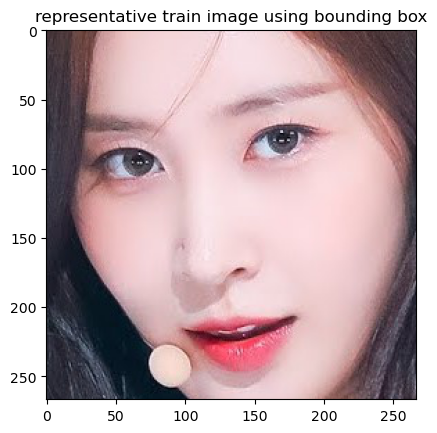

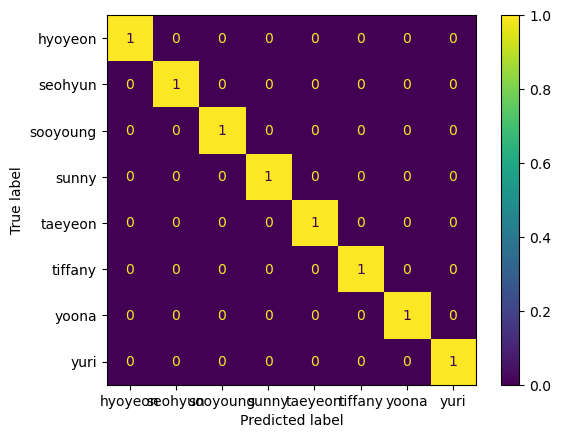

              precision    recall  f1-score   support

     hyoyeon       1.00      1.00      1.00         1
     seohyun       1.00      1.00      1.00         1
    sooyoung       1.00      1.00      1.00         1
       sunny       1.00      1.00      1.00         1
     taeyeon       1.00      1.00      1.00         1
     tiffany       1.00      1.00      1.00         1
       yoona       1.00      1.00      1.00         1
        yuri       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


Training complete!


In [5]:
if __name__ == "__main__":
    # STEP 1: Train the KNN classifier and save it to disk
    # Once the model is trained and saved, you can skip this step next time.
    print("Training KNN classifier...")
    
    # train 이미지 각 3장, val 이미지 각 1장
    
    classifier = train("train_소녀시대","val_소녀시대",model_save_path="trained_knn_model_소녀시대.clf", n_neighbors=3)
    
    print("Training complete!")


# Test

Looking for faces in 아이브 단사2.jpg
The test image has a distance of 0.42 from known image #0

The test image has a distance of 0.4 from known image #1

The test image has a distance of 0.46 from known image #2

The test image has a distance of 0.51 from known image #3

The test image has a distance of 0.51 from known image #4

The test image has a distance of 0.54 from known image #5

The test image has a distance of 0.56 from known image #6

The test image has a distance of 0.57 from known image #7

The test image has a distance of 0.43 from known image #8

The test image has a distance of 0.62 from known image #9

The test image has a distance of 0.59 from known image #10

The test image has a distance of 0.58 from known image #11

The test image has a distance of 0.5 from known image #12

The test image has a distance of 0.52 from known image #13

The test image has a distance of 0.55 from known image #14

The test image has a distance of 0.61 from known image #15

The test image has 

C:\Users\user\AppData\Local\Temp\ipykernel_14964\3236808682.py:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(encoded_name)
C:\Users\user\AppData\Local\Temp\ipykernel_14964\3236808682.py:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(encoded_name)
C:\Users\user\AppData\Local\Temp\ipykernel_14964\3236808682.py:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(encoded_name)
C:\Users\user\AppData\Local\Temp\ipykernel_14964\3236808682.py:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(encoded_name)


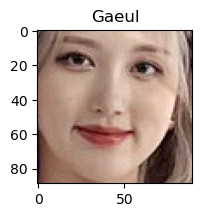

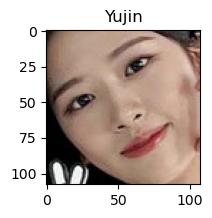

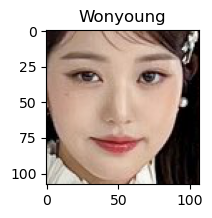

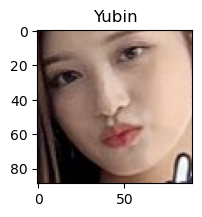

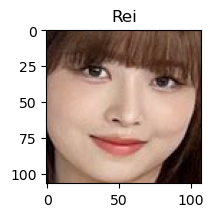

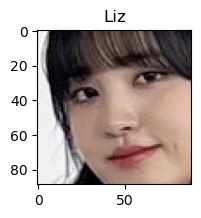

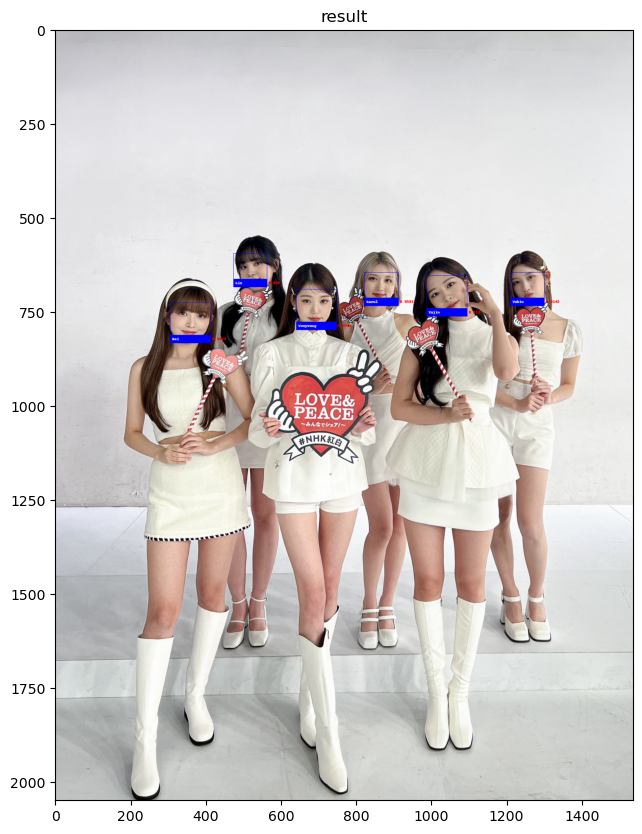

In [7]:
# STEP 2: Using the trained classifier, make predictions for unknown images
for image_file in os.listdir("test_소녀시대"):
    full_file_path = os.path.join("test_소녀시대", image_file)

    print("Looking for faces in {}".format(image_file))

    # Find all people in the image using a trained classifier model
    # Note: You can pass in either a classifier file name or a classifier model instance
    start_time = time.time()
    predictions = predict("train_소녀시대",full_file_path, model_path="trained_knn_model_소녀시대.clf")
    Total_time = time.time() - start_time # time_taken is in seconds
    hours, rest = divmod(Total_time,3600)
    minutes, seconds = divmod(rest, 60)
    hour = math.trunc(hours)
    minute = math.trunc(minutes)
    second = math.trunc(seconds)
    print("총 소요시간: {}시간 {}분 {}초" .format(hour, minute, second))
    
    # Print results on the console
    for name, (top, right, bottom, left) in predictions:
        print("- Found {} at ({}, {})".format(name, left, top))

    # Display results overlaid on an image
    show_prediction_labels_on_image(os.path.join("test_소녀시대", image_file), "train_소녀시대", predictions)